https://amazon-reviews-2023.github.io/

In [1]:
import os
import sys
import itertools

import scipy.sparse as sp
import numpy as np
import pandas as pd

import cornac
from cornac.eval_methods import RatioSplit, BaseMethod, StratifiedSplit
from cornac.metrics import FMeasure, RMSE, NCRR, NDCG, Precision, Recall
from cornac.models import BaselineOnly, MF, NMF, BPR, WMF, EASE

import optuna

from datetime import datetime
import random

import matplotlib.pyplot as plt
import pickle
import builtins

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

SEED = 42
VERBOSE = False
TOP_X = 50

System version: 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:47:54) [MSC v.1941 64 bit (AMD64)]
Cornac version: 2.3.2


In [2]:
raw_data = pd.read_parquet('5_category_final_table_(767,684 rows).parquet')

In [8]:
print(len(full_df['parent_asin'].unique()))

584


In [3]:
full_df = raw_data.copy()

# Data Analysis

In [57]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767684 entries, 0 to 767683
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   rating                  767684 non-null  int32              
 1   title_review            767623 non-null  object             
 2   text                    767277 non-null  object             
 3   parent_asin             767684 non-null  object             
 4   user_id                 767684 non-null  object             
 5   helpful_vote            767684 non-null  int64              
 6   title_meta              767684 non-null  object             
 7   price                   675350 non-null  float64            
 8   store                   760314 non-null  object             
 9   features_clean          767684 non-null  object             
 10  description_clean       767684 non-null  object             
 11  timestamp_utc           76

In [58]:
full_df.head()

,rating,title_review,text,parent_asin,user_id,helpful_vote,title_meta,price,store,features_clean,...,timestamp_utc,category_depth,verified_purchase_flag,cat_1,cat_2,cat_3,cat_4,price_log,helpful_vote_clipped,avg_rating_parent
0,1,only 1 worked correctly,i ordered this set right before my camping tri...,B09LW2KHPM,AGO25X54UAIXSKHOAH4SG2VUDUNA,1,"vont led camping lantern, led lanterns, suitab...",14.38,vont,bright & lasting - equipped with 30 crazy brig...,...,2020-11-11 07:10:55.679000+00:00,6,1,outdoor recreation,camping & hiking,lights & lanterns,lanterns,2.733068,1,4.7
1,5,lightweight and quiet,this bike is nice and simple. easy to build an...,B0BTDLFXSL,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,0,ativafit exercise bike foldable fitness indoor...,139.99,ativafit,digital monitor shows your data - monitor your...,...,2020-05-17 22:40:46.636000+00:00,4,1,exercise & fitness,cardio training,exercise bikes,exercise bikes,4.948689,0,4.3
2,5,great little tent,"i love the alps tent. it is light, super easy...",B09W4W9JB5,AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,0,alps mountaineering lynx 1-person backpacking ...,109.99,alps mountaineering,100% polyester imported great backpacking tent,...,2019-09-01 01:46:16.061000+00:00,5,0,outdoor recreation,camping & hiking,tents & shelters,tents,4.709440,0,4.7
3,5,very cute,"bought this for my son’s birthday, super cute ...",B07Z6Y87XH,AEGEQO4R6APZMUYEYT2VGJ3BKKAQ,0,raskullz mohawk toddler 3+ and child 5+ helmets,35.49,raskullz,design - kids love the red bendable 3d rubber ...,...,2020-11-16 19:07:19.645000+00:00,5,1,sports,cycling,kids' bikes & accessories,kids' helmets,3.597038,0,4.7
4,5,my pooches love it!,we purchased this two person tent for our dogs...,B09HRDWXCK,AEDAZ44DKSCBHMY4VOCU6Z7DWM7A,3,2-person camping tent – includes rain fly and ...,45.94,wakeman,100% polyester imported 2 person tent – this l...,...,2016-02-24 17:58:45+00:00,5,1,outdoor recreation,camping & hiking,tents & shelters,tents,3.848870,3,3.6


In [59]:
print(f"Count of unique user id in train: {len(full_df['user_id'].unique())}")
print(f"Count of unique item id in train: {len(full_df['parent_asin'].unique())}")

Count of unique user id in train: 649151
Count of unique item id in train: 584


In [60]:
pd.crosstab(full_df['rating'], full_df['verified_purchase_flag'])

verified_purchase_flag,0,1
rating,,
1,5748,50862
2,3097,29952
3,3376,45165
4,6175,94818
5,27083,501408


In [61]:
pd.crosstab(full_df['rating'], full_df['helpful_vote_clipped'])

helpful_vote_clipped,0,1,2,3,4,5
rating,,,,,,
1,30523,11730,4751,2402,1480,5724
2,23067,5813,1682,732,440,1315
3,35453,7370,2197,1025,568,1928
4,79757,11895,3417,1504,886,3534
5,449449,47833,11926,4990,2493,11800


In [62]:
for t in [5.0, 4.0, 3.0, 2.0, 1.0]:
    pos_users = full_df[full_df['rating'] >= t]['user_id'].nunique()
    print(f"Threshold >= {t}: {pos_users} users with at least 1 relevant item")

Threshold >= 5.0: 462064 users with at least 1 relevant item
Threshold >= 4.0: 540231 users with at least 1 relevant item
Threshold >= 3.0: 577261 users with at least 1 relevant item
Threshold >= 2.0: 603297 users with at least 1 relevant item
Threshold >= 1.0: 649151 users with at least 1 relevant item


In [63]:
# Number of non-zero entries (observed interactions)
num_interactions = len(full_df['rating'])

# Total possible entries
total_entries = len(full_df['user_id'].unique()) * len(full_df['parent_asin'].unique())

# Sparsity
sparsity = 1 - (num_interactions / total_entries)

print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")

Sparsity: 0.9980 (99.80%)


# Create Item Dataset

In [64]:
# Restore a Item dateset
items_df = full_df[['parent_asin', 'cat_2', 'cat_4']].drop_duplicates().reset_index(drop=True)
items_df.head()

,parent_asin,cat_2,cat_4
0,B09LW2KHPM,camping & hiking,lanterns
1,B0BTDLFXSL,cardio training,exercise bikes
2,B09W4W9JB5,camping & hiking,tents
3,B07Z6Y87XH,cycling,kids' helmets
4,B09HRDWXCK,camping & hiking,tents


# Create Interacted Dataset

In [65]:
# Create a Interacted Dataset
interacted_df = full_df[['user_id', 'parent_asin','cat_2', 'cat_4']]
interacted_df.head()

,user_id,parent_asin,cat_2,cat_4
0,AGO25X54UAIXSKHOAH4SG2VUDUNA,B09LW2KHPM,camping & hiking,lanterns
1,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,B0BTDLFXSL,cardio training,exercise bikes
2,AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,B09W4W9JB5,camping & hiking,tents
3,AEGEQO4R6APZMUYEYT2VGJ3BKKAQ,B07Z6Y87XH,cycling,kids' helmets
4,AEDAZ44DKSCBHMY4VOCU6Z7DWM7A,B09HRDWXCK,camping & hiking,tents


# Create UIR Dataset

In [66]:
uir_dataset = cornac.data.Dataset.from_uir(
    list(full_df[['user_id', 'parent_asin', 'rating']].itertuples(index=False, name=None))
)
R = uir_dataset.matrix.toarray()
R_mask = (R > 0).astype(float)
pd.DataFrame(
  data=R,
  index=[f"User {uir_dataset.user_ids[u]}" for u in np.arange(uir_dataset.num_users)],
  columns=[f"Item {uir_dataset.item_ids[i]}" for i in np.arange(uir_dataset.num_items)]
).replace(0, np.nan)

C:\Users\pakke\anaconda3\envs\p312\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1698 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


,Item B09LW2KHPM,Item B0BTDLFXSL,Item B09W4W9JB5,Item B07Z6Y87XH,Item B09HRDWXCK,Item B000KC009Y,Item B0C6H9K5NF,Item B00INQVYZ8,Item B078FHD1ZH,Item B0855B4QZR,...,Item B0C6KP8SRQ,Item B0B829WR28,Item B0C1BD44L9,Item B0864RK56W,Item B07RHPQ3FW,Item B0917VV12K,Item B0B4M6Z2GH,Item B00H90PFOK,Item B07BM1RK7K,Item B077KGFWJ9
User AGO25X54UAIXSKHOAH4SG2VUDUNA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User AHGGRLIBAWVH44XAY2QHQOE7S6OQ,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User AEGEQO4R6APZMUYEYT2VGJ3BKKAQ,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User AEDAZ44DKSCBHMY4VOCU6Z7DWM7A,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User AGJHIOTHTLUFIWCJUSNIW35RMYRQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User AE4TJGRYAKCRX7BHLJGWUUP6ZQPQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User AEYUKKCRDBX4SCDNEBVYQQ2TORRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User AESGZS7KSDLXD6OXRMLICJWVE57Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Helper Functions

In [67]:
def convert_df_to_cornac_format(df, model=None):
    """
    Converts a Pandas DataFrame to Cornac-compatible (user, item, rating/confidence) triplets
    based on the model type.

    Parameters:
        df (pd.DataFrame): Must contain 'user_id', 'parent_asin', and relevant columns
        model (str): One of 'BPR', 'WMF', 'MF', or 'EASE'

    Returns:
        List of (user, item, score) triplets
    """
    df = df.copy()

    if model in {"BPR", "EASE"}:
        # Binary implicit feedback (1 if purchased or helped)
        df['interaction'] = ((df['verified_purchase_flag'] == 1) | (df['helpful_vote_clipped'] > 0)).astype(np.float32)
        r = 'interaction'

    elif model == "WMF":
        # Confidence score (clipped helpful votes)
        df['confidence'] = df['helpful_vote_clipped'].fillna(0).astype(np.float32)
        r = 'confidence'

    elif model == "MF":
        # Explicit feedback model
        if "rating" not in df.columns:
            raise ValueError("DataFrame must contain a 'rating' column for MF.")
        r = "rating"

    else:
        raise ValueError(f"Unsupported model type: {model}")

    return list(zip(
        df['user_id'].astype(str).values,
        df['parent_asin'].astype(str).values,
        df[r].astype(np.float32).values
    ))


In [68]:
# --- Shared setup ---
def run_experiment(model, model_name, full_data, rating_threshold=4.0):
    ev = RatioSplit(
    data=full_data,
    test_size=0.2,
    rating_threshold=rating_threshold,
    exclude_unknowns=True,
    seed=SEED,
    verbose=VERBOSE
    )

    metrics = [Recall(k=50), FMeasure(k=50), NCRR(k=50), NDCG(k=50)]
    exp = cornac.Experiment(eval_method=ev, models=[model], metrics=metrics, save_dir=None, verbose=False)

    # UTF-8 patch to fix UnicodeEncodeError (for EASE)
    def safe_utf8_open(*args, **kwargs):
        if len(args) >= 2 and isinstance(args[1], str) and 'b' in args[1]:
            # Binary mode
            return open_backup(*args, **kwargs)
        # Text mode – enforce UTF-8 encoding
        kwargs.setdefault('encoding', 'utf-8')
        return open_backup(*args, **kwargs)
            
    open_backup = builtins.open
    exp.run()
    builtins.open = safe_utf8_open  # Restore open()
    return exp.result[0].metric_avg_results, exp.result[0]

# --- MF tuning only ---
def objective_mf(trial):
    k = trial.suggest_int("k", 10, 200)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.05, log=True)
    lambda_reg = trial.suggest_float("lambda_reg", 0.001, 0.1, log=True)
    max_iter = 100

    model = MF(
        k=k,
        max_iter=max_iter,
        learning_rate=learning_rate,
        lambda_reg=lambda_reg,
        use_bias=True,  # Optional: can set to False if you want unbiased MF
        seed=SEED,
        verbose=VERBOSE
    )

    metrics, result = run_experiment(
        model=model,
        model_name="MF",
        full_data=rating_data,            # assumed explicit ratings (e.g., 1–5)
        rating_threshold=4.0
    )

    trial.set_user_attr("result", result)
    return metrics["F1@50"]

# --- BPR tuning only ---
def objective_bpr(trial):
    k = trial.suggest_int("k", 100, 200)
    lr = trial.suggest_float("learning_rate", 0.001, 0.05, log=True)
    lambda_reg = trial.suggest_float("lambda_reg", 0.001, 0.1, log=True)
    max_iter = 500

    model = BPR(k=k, max_iter=max_iter, learning_rate=lr,
                lambda_reg=lambda_reg, seed=SEED, verbose=VERBOSE)
    metrics, result = run_experiment(model, "BPR", interaction_data, rating_threshold=0.5)

    trial.set_user_attr("result", result)
    return metrics["F1@50"]

# --- WMF tuning only ---
def objective_wmf(trial):
    k = trial.suggest_int("k", 50, 250)
    lr = trial.suggest_float("learning_rate", 0.001, 0.05, log=True)
    lambda_u = trial.suggest_float("lambda_u", 0.001, 0.1, log=True)
    lambda_v = trial.suggest_float("lambda_v", 0.001, 0.1, log=True)
    a = trial.suggest_float("a", 1.0, 10.0)
    b = trial.suggest_float("b", 0.0001, 0.01, log=True)
    max_iter = 50
    #max_iter = trial.suggest_int("max_iter", 100, 400)

    model = WMF(k=k, max_iter=max_iter, a=a, b=b, learning_rate=lr,
                lambda_u=lambda_u, lambda_v=lambda_v, seed=SEED, verbose=VERBOSE)
    metrics, result = run_experiment(model, "WMF", confidence_data, rating_threshold=0.5)
    trial.set_user_attr("result", result)
    return metrics["F1@50"]
    
# --- EASE tuning only ---
def objective_ease(trial):
    lamb = trial.suggest_float("lamb", 10.0, 1000.0, log=True)

    model = EASE(lamb=lamb, verbose=VERBOSE)
    metrics, result = run_experiment(
        model=model,
        model_name="EASE",
        full_data=interaction_data,
        rating_threshold=0.5
    )

    trial.set_user_attr("result", result)
    return metrics["F1@50"]

In [69]:
def generate_top_k_recommendations(model_class, dataset, study=None, k=10, model_path=None):
    """
    Generate top-k item recommendations for a sample of users using a trained Cornac model.
    
    Parameters:
        model_class: Cornac model class (e.g., BPR, WMF, MF, EASE)
        dataset: Cornac-format dataset
        study: Optuna study object (optional)
        k: number of top items per user
        model_path: optional path to load a pickled model

    Returns:
        pd.DataFrame: top-k item IDs per user
    """
    # === Extract best parameters ===
    best_params = study.best_params if study else {}

    # === Load model if path provided ===
    if model_path:
        with open(model_path, "rb") as f:
            model = pickle.load(f)
        print(f"Loaded model from: {model_path}")
    else:
        # === Generate model name for logging/debugging ===
        if study:
            if model_class.__name__ == "WMF":
                model_name = (
                    f"WMF(k={best_params['k']}, lr={best_params['learning_rate']:.4f}, "
                    f"lambda_u={best_params['lambda_u']:.4f}, lambda_v={best_params['lambda_v']:.4f}, "
                    f"a={best_params['a']}, b={best_params['b']:.4f}, it=50)"
                )
            elif model_class.__name__ == "BPR":
                model_name = (
                    f"BPR(k={best_params['k']}, lr={best_params['learning_rate']:.4f}, "
                    f"lambda_reg={best_params['lambda_reg']:.4f}, it=500)"
                )
            elif model_class.__name__ == "EASE":
                model_name = f"EASE(lamb={best_params['lamb']:.2f})"
            elif model_class.__name__ == "MF":
                model_name = (
                    f"MF(k={best_params['k']}, lr={best_params['learning_rate']:.4f}, "
                    f"lambda_reg={best_params['lambda_reg']:.4f}, use_bias={best_params.get('use_bias', True)})"
                )
            else:
                model_name = f"{model_class.__name__}_tuned"
        else:
            model_name = f"{model_class.__name__}_default"

        # === Instantiate and train model ===
        model = model_class(
            **best_params,
            seed=SEED,
            verbose=VERBOSE,
            name=model_name
        )
        model.fit(dataset)

    # === Extract mapping from train set ===
    train_set = model.train_set
    id2raw_iid = {v: k for k, v in train_set.iid_map.items()}
    id2raw_uid = {v: k for k, v in train_set.uid_map.items()}
    user_indices = sorted(range(train_set.num_users), key=lambda x: id2raw_uid[x])
    sampled_user_indices = random.sample(user_indices, k=100)

    # === Generate top-k items per user ===
    all_top_k = []
    for uid in sampled_user_indices:
        scores = np.asarray(model.score(user_idx=uid)).flatten()
        top_iids = np.argsort(-scores)[:k]
        raw_iids = [id2raw_iid[i] for i in top_iids]
        all_top_k.append(raw_iids)

    # === Return as DataFrame ===
    df_topk = pd.DataFrame(all_top_k, index=[id2raw_uid[uid] for uid in sampled_user_indices])
    df_topk.index.name = "user_id"

    return df_topk


In [70]:
def annotate_recommendations_with_category(df_topk, items_df):
    """
    Converts wide-format top-k recommendation DataFrame into long format and 
    joins with item metadata (cat_2, cat_4).

    Parameters:
        df_topk (pd.DataFrame): Top-k recommendations (users as index, items as columns).
        items_df (pd.DataFrame): Item metadata with columns ['parent_asin', 'cat_2', 'cat_4'].

    Returns:
        pd.DataFrame: Long-format DataFrame with user_id, rank (1-based), parent_asin, cat_2, cat_4.
    """
    # Flatten to long format
    df_long = df_topk.reset_index().melt(id_vars='user_id', var_name='rank', value_name='parent_asin')
    
    # Merge with metadata
    df_merged = df_long.merge(items_df[['parent_asin', 'cat_2', 'cat_4']], on='parent_asin', how='left')
    
    # Convert rank to 1-based integer
    df_merged['rank'] = df_merged['rank'].astype(int) + 1
    
    # Sort result
    df_merged = df_merged.sort_values(by=['user_id', 'rank'])

    return df_merged


In [71]:
import pandas as pd

def compute_cat2_diff_cat4_rate(interacted_df, recommendation_df):
    """
    Computes the rate of recommendations that match the user's rated `cat_2`
    but have different `cat_4`.

    Parameters:
        interacted_df (pd.DataFrame): User-item interactions with columns:
            ['user_id', 'parent_asin', 'cat_2', 'cat_4']
        recommendation_df (pd.DataFrame): Recommendations with:
            ['user_id', 'parent_asin', 'cat_2', 'cat_4']

    Returns:
        overall_rate (float): Fraction of recommended items that are in the same
                              `cat_2` but not in the same `cat_4` as the rated ones.
        labeled_recommendations (pd.DataFrame): recommendation_df with an added
                                                'cat_match' column.
        user_rate (pd.Series): Per-user rate of 'same_cat2_diff_cat4' items.
    """
    # Build per-user sets of rated categories
    rated_cat2 = interacted_df.groupby('user_id')['cat_2'].apply(set)
    rated_cat4 = interacted_df.groupby('user_id')['cat_4'].apply(set)

    # Helper to assign match label
    def label_category_match(row):
        user = row['user_id']
        c2 = row['cat_2']
        c4 = row['cat_4']
        cat2_set = rated_cat2.get(user, set())
        cat4_set = rated_cat4.get(user, set())
        if c4 in cat4_set:
            return 'same_cat4'
        elif c2 in cat2_set:
            return 'same_cat2_diff_cat4'
        else:
            return 'diff_cat2'

    # Apply labeling
    recommendation_df = recommendation_df.copy()
    recommendation_df['cat_match'] = recommendation_df.apply(label_category_match, axis=1)

    # Compute overall rate
    overall_rate = (recommendation_df['cat_match'] == 'same_cat2_diff_cat4').mean()

    # Per-user rate
    user_rate = (
        recommendation_df.groupby('user_id')['cat_match']
        .apply(lambda x: (x == 'same_cat2_diff_cat4').mean())
    )

    return overall_rate, recommendation_df, user_rate


# Create Interaction, Confidence Data ad Rating Data for Models

In [72]:
interaction_data = convert_df_to_cornac_format(full_df, model="BPR")
confidence_data = convert_df_to_cornac_format(full_df, model="WMF")
rating_data = convert_df_to_cornac_format(full_df, model="MF")


In [73]:
N = 15
now = datetime.now().strftime("%Y%m%d_%H%M%S")

# MF

In [74]:
# Run MF optimization
study_mf = optuna.create_study(direction='maximize')
study_mf.optimize(objective_mf, n_trials=N)

# Save best model
best_trial = study_mf.best_trial
if "result" in best_trial.user_attrs:
    best_model = best_trial.user_attrs["result"]

    # Ensure train_set is included
    if not hasattr(best_model, "train_set"):
        print("Warning: No train_set found in best_model.")
    else:
        best_model.train_set = best_model.train_set  # explicitly attach

    with open("mf_model_with_trainset.pkl", "wb") as f:
        pickle.dump(best_model, f)

    print("Best MF model saved to mf_model_with_trainset.pkl")

# Collect all trial results
mf_rows = []
for trial in study_mf.trials:
    if trial.value is None:
        continue
    trial_data = {
        "Trial": trial.number,
        "F1@50": trial.value,
        "Model": "MF",
        **trial.params
    }

    # Add additional metrics from trial's result (if present)
    if "result" in trial.user_attrs:
        for metric, value in trial.user_attrs["result"].metric_avg_results.items():
            trial_data[metric] = value

    mf_rows.append(trial_data)

# Convert to DataFrame and export
mf_results_df = pd.DataFrame(mf_rows)


[I 2025-06-17 15:31:19,994] A new study created in memory with name: no-name-0ec7d80e-033c-4f6e-8318-937cba0df3f6
C:\Users\pakke\anaconda3\envs\p312\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1077 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
C:\Users\pakke\anaconda3\envs\p312\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 39 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0040 |  0.0097 |  0.0260 |    0.0958 |   23.1322 |  14.5490



[I 2025-06-17 15:32:00,297] Trial 0 finished with value: 0.004044227116494557 and parameters: {'k': 173, 'learning_rate': 0.001647285822177527, 'lambda_reg': 0.013501841072834326}. Best is trial 0 with value: 0.004044227116494557.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0044 |  0.0139 |  0.0310 |    0.1038 |   15.8270 |  13.0808



[I 2025-06-17 15:32:31,953] Trial 1 finished with value: 0.004361476230725871 and parameters: {'k': 111, 'learning_rate': 0.0016933974082352578, 'lambda_reg': 0.0012472940391233653}. Best is trial 1 with value: 0.004361476230725871.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0043 |  0.0140 |  0.0309 |    0.1029 |   25.5765 |  12.0894



[I 2025-06-17 15:33:12,575] Trial 2 finished with value: 0.004340768335573334 and parameters: {'k': 199, 'learning_rate': 0.004726643788481928, 'lambda_reg': 0.006980964892924002}. Best is trial 1 with value: 0.004361476230725871.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0039 |  0.0119 |  0.0272 |    0.0925 |   20.9099 |  12.8749



[I 2025-06-17 15:33:49,119] Trial 3 finished with value: 0.003899827451254143 and parameters: {'k': 164, 'learning_rate': 0.03895139830987074, 'lambda_reg': 0.07586857380840076}. Best is trial 1 with value: 0.004361476230725871.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0042 |  0.0135 |  0.0301 |    0.1002 |   13.7270 |  13.2329



[I 2025-06-17 15:34:18,759] Trial 4 finished with value: 0.0042397461674030315 and parameters: {'k': 105, 'learning_rate': 0.021867279489203865, 'lambda_reg': 0.008646975983398416}. Best is trial 1 with value: 0.004361476230725871.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0037 |  0.0089 |  0.0238 |    0.0884 |    4.7654 |  12.2690



[I 2025-06-17 15:34:38,716] Trial 5 finished with value: 0.0037170732121429447 and parameters: {'k': 27, 'learning_rate': 0.0010476615851847408, 'lambda_reg': 0.02982487770921361}. Best is trial 1 with value: 0.004361476230725871.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0043 |  0.0160 |  0.0324 |    0.1018 |   25.9593 |  12.3585



[I 2025-06-17 15:35:19,856] Trial 6 finished with value: 0.004304606409908761 and parameters: {'k': 194, 'learning_rate': 0.0041891000414099235, 'lambda_reg': 0.0018809916376636912}. Best is trial 1 with value: 0.004361476230725871.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0038 |  0.0096 |  0.0248 |    0.0900 |   18.0534 |  13.2929



[I 2025-06-17 15:35:54,073] Trial 7 finished with value: 0.0037913698749922507 and parameters: {'k': 129, 'learning_rate': 0.0035794196616162205, 'lambda_reg': 0.046099665642046345}. Best is trial 1 with value: 0.004361476230725871.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0043 |  0.0141 |  0.0309 |    0.1019 |   21.4346 |  13.2196



[I 2025-06-17 15:36:31,601] Trial 8 finished with value: 0.0042963808130384975 and parameters: {'k': 152, 'learning_rate': 0.045260368732379715, 'lambda_reg': 0.004571932920637526}. Best is trial 1 with value: 0.004361476230725871.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0042 |  0.0117 |  0.0282 |    0.0993 |   13.8490 |  12.7875



[I 2025-06-17 15:37:00,943] Trial 9 finished with value: 0.004188775246796132 and parameters: {'k': 99, 'learning_rate': 0.017970266962505213, 'lambda_reg': 0.04158666980994998}. Best is trial 1 with value: 0.004361476230725871.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0045 |  0.0144 |  0.0321 |    0.1068 |    4.2750 |  13.0570



[I 2025-06-17 15:37:21,082] Trial 10 finished with value: 0.004523096110835379 and parameters: {'k': 24, 'learning_rate': 0.0019524669598189593, 'lambda_reg': 0.00126236289076509}. Best is trial 10 with value: 0.004523096110835379.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0045 |  0.0142 |  0.0319 |    0.1067 |    6.1133 |  12.5678



[I 2025-06-17 15:37:42,531] Trial 11 finished with value: 0.004493920320044219 and parameters: {'k': 37, 'learning_rate': 0.0017177865738024754, 'lambda_reg': 0.001042555172223737}. Best is trial 10 with value: 0.004523096110835379.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0045 |  0.0137 |  0.0313 |    0.1055 |    4.1290 |  13.4303



[I 2025-06-17 15:38:02,806] Trial 12 finished with value: 0.004461881158890469 and parameters: {'k': 24, 'learning_rate': 0.001968402532569036, 'lambda_reg': 0.002140832223919152}. Best is trial 10 with value: 0.004523096110835379.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0044 |  0.0139 |  0.0311 |    0.1038 |    8.7934 |  12.5311



[I 2025-06-17 15:38:27,024] Trial 13 finished with value: 0.004398593533663094 and parameters: {'k': 61, 'learning_rate': 0.009004191058220576, 'lambda_reg': 0.001092017497788204}. Best is trial 10 with value: 0.004523096110835379.



TEST:
...
   |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-- + ------ + ------- + ------- + --------- + --------- + --------
MF | 0.0044 |  0.0129 |  0.0305 |    0.1046 |    8.2649 |  13.0671



[I 2025-06-17 15:38:50,965] Trial 14 finished with value: 0.004411061704743654 and parameters: {'k': 58, 'learning_rate': 0.0026106584184539244, 'lambda_reg': 0.003220079461378271}. Best is trial 10 with value: 0.004523096110835379.


⚠️ Warning: No train_set found in best_model.
✅ Best MF model saved to mf_model_with_trainset.pkl


## Generate Top K Recommendations for Sampled 100 Users

In [75]:
mf_topk_df = generate_top_k_recommendations(MF, uir_dataset, study_mf, k=10)

## Final Recommendations

In [76]:
mf_recommendation_df = annotate_recommendations_with_category(mf_topk_df, items_df)

In [77]:
mf_recommendation_df.head()

,user_id,rank,parent_asin,cat_2,cat_4
61,AE2A77MDQE52XTHZ44MFODEJ22GQ,1,B00OUGNUO8,cardio training,rowers
161,AE2A77MDQE52XTHZ44MFODEJ22GQ,2,B0C6KLM5HM,camping & hiking,lanterns
261,AE2A77MDQE52XTHZ44MFODEJ22GQ,3,B00F9F6OVK,camping & hiking,cots & hammocks
361,AE2A77MDQE52XTHZ44MFODEJ22GQ,4,B0BXHLWCR5,camping & hiking,hand & foot warmers
461,AE2A77MDQE52XTHZ44MFODEJ22GQ,5,B09DX9KS81,camping & hiking,trekking poles


In [78]:
# Compute intra-category diversity rate for MF
mf_overall_rate, mf_labeled_recs, mf_user_rates = compute_cat2_diff_cat4_rate(interacted_df, mf_recommendation_df)

# Print overall result
print(f"Overall Same Main Cat but Diff Sub-cat Rate (MF): {mf_overall_rate:.2%}")


Overall Same Main Cat but Diff Sub-cat Rate (MF): 39.90%


In [79]:
mf_labeled_recs.head()

,user_id,rank,parent_asin,cat_2,cat_4,cat_match
61,AE2A77MDQE52XTHZ44MFODEJ22GQ,1,B00OUGNUO8,cardio training,rowers,diff_cat2
161,AE2A77MDQE52XTHZ44MFODEJ22GQ,2,B0C6KLM5HM,camping & hiking,lanterns,same_cat2_diff_cat4
261,AE2A77MDQE52XTHZ44MFODEJ22GQ,3,B00F9F6OVK,camping & hiking,cots & hammocks,same_cat2_diff_cat4
361,AE2A77MDQE52XTHZ44MFODEJ22GQ,4,B0BXHLWCR5,camping & hiking,hand & foot warmers,same_cat2_diff_cat4
461,AE2A77MDQE52XTHZ44MFODEJ22GQ,5,B09DX9KS81,camping & hiking,trekking poles,same_cat2_diff_cat4


# BPR

In [80]:
# Run BPR optimization
study_bpr = optuna.create_study(direction='maximize')
study_bpr.optimize(objective_bpr, n_trials=N)

# Save best model
best_trial = study_bpr.best_trial
if "result" in best_trial.user_attrs:
    best_model = best_trial.user_attrs["result"]

    # Ensure train_set is included
    if not hasattr(best_model, "train_set"):
        print("Warning: No train_set found in best_model.")
    else:
        best_model.train_set = best_model.train_set  # explicitly attach

    with open("bpr_model_with_trainset.pkl", "wb") as f:
        pickle.dump(best_model, f)

    print("Best BPR model saved to bpr_model_with_trainset.pkl")

# Collect all trial results
bpr_rows = []
for trial in study_bpr.trials:
    if trial.value is None:
        continue
    trial_data = {
        "Trial": trial.number,
        "F1@50": trial.value,
        "Model": "BPR",
        **trial.params
    }

    # Add other evaluation metrics from user_attrs["result"]
    if "result" in trial.user_attrs:
        for metric, value in trial.user_attrs["result"].metric_avg_results.items():
            trial_data[metric] = value

    bpr_rows.append(trial_data)

# Convert to DataFrame and export
bpr_results_df = pd.DataFrame(bpr_rows)


[I 2025-06-17 15:39:17,283] A new study created in memory with name: no-name-097c7692-ecf4-4761-9494-5bb7510230a8
C:\Users\pakke\anaconda3\envs\p312\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1077 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
C:\Users\pakke\anaconda3\envs\p312\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 39 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0135 |  0.0681 |  0.1172 |    0.3164 |  224.2016 |  14.2527



[I 2025-06-17 15:43:18,578] Trial 0 finished with value: 0.013523205965142908 and parameters: {'k': 118, 'learning_rate': 0.00899531767436473, 'lambda_reg': 0.0029465075027393962}. Best is trial 0 with value: 0.013523205965142908.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0138 |  0.0682 |  0.1182 |    0.3241 |  239.8168 |  15.0205



[I 2025-06-17 15:47:36,499] Trial 1 finished with value: 0.01382784454038158 and parameters: {'k': 136, 'learning_rate': 0.007023429530792671, 'lambda_reg': 0.0037403296089246188}. Best is trial 1 with value: 0.01382784454038158.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0106 |  0.0361 |  0.0778 |    0.2498 |  234.3400 |  14.6704



[I 2025-06-17 15:51:48,528] Trial 2 finished with value: 0.010583893201283773 and parameters: {'k': 133, 'learning_rate': 0.004938965868959811, 'lambda_reg': 0.06678961294404487}. Best is trial 1 with value: 0.01382784454038158.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0105 |  0.0358 |  0.0772 |    0.2477 |  226.2635 |  14.3367



[I 2025-06-17 15:55:52,202] Trial 3 finished with value: 0.010496872577961424 and parameters: {'k': 125, 'learning_rate': 0.0016936875335844107, 'lambda_reg': 0.024522970803250922}. Best is trial 1 with value: 0.01382784454038158.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0126 |  0.0493 |  0.0976 |    0.2947 |  270.5133 |  14.1052



[I 2025-06-17 16:00:40,016] Trial 4 finished with value: 0.012570834582453111 and parameters: {'k': 167, 'learning_rate': 0.003366953739499134, 'lambda_reg': 0.010769528954776125}. Best is trial 1 with value: 0.01382784454038158.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0121 |  0.0411 |  0.0883 |    0.2835 |  279.3321 |  14.5530



[I 2025-06-17 16:05:36,731] Trial 5 finished with value: 0.012092047859602434 and parameters: {'k': 195, 'learning_rate': 0.010925338644141754, 'lambda_reg': 0.06695429920942593}. Best is trial 1 with value: 0.01382784454038158.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0103 |  0.0354 |  0.0763 |    0.2441 |  274.8401 |  14.0729



[I 2025-06-17 16:10:28,533] Trial 6 finished with value: 0.010338370085738196 and parameters: {'k': 182, 'learning_rate': 0.007112751739847619, 'lambda_reg': 0.08748561236494252}. Best is trial 1 with value: 0.01382784454038158.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0116 |  0.0377 |  0.0833 |    0.2721 |  262.4602 |  14.2354



[I 2025-06-17 16:15:08,067] Trial 7 finished with value: 0.011609545020612578 and parameters: {'k': 164, 'learning_rate': 0.0035579731751207867, 'lambda_reg': 0.023126544455423437}. Best is trial 1 with value: 0.01382784454038158.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0162 |  0.0840 |  0.1423 |    0.3772 |  199.7722 |  14.8561



[I 2025-06-17 16:18:45,800] Trial 8 finished with value: 0.01616302070917802 and parameters: {'k': 102, 'learning_rate': 0.029114879234582614, 'lambda_reg': 0.045775255618143475}. Best is trial 8 with value: 0.01616302070917802.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0130 |  0.0543 |  0.1036 |    0.3045 |  220.5885 |  15.7906



[I 2025-06-17 16:22:45,015] Trial 9 finished with value: 0.01300700128097392 and parameters: {'k': 130, 'learning_rate': 0.006151981306304769, 'lambda_reg': 0.023260315557108724}. Best is trial 8 with value: 0.01616302070917802.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0147 |  0.0894 |  0.1403 |    0.3438 |  196.0516 |  15.5451



[I 2025-06-17 16:26:19,744] Trial 10 finished with value: 0.01470938926984212 and parameters: {'k': 102, 'learning_rate': 0.04359312256920214, 'lambda_reg': 0.008921154802025493}. Best is trial 8 with value: 0.01616302070917802.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0144 |  0.0901 |  0.1396 |    0.3374 |  196.2254 |  14.9953



[I 2025-06-17 16:29:54,018] Trial 11 finished with value: 0.014422655212499715 and parameters: {'k': 103, 'learning_rate': 0.04793865739453471, 'lambda_reg': 0.006926571814681638}. Best is trial 8 with value: 0.01616302070917802.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0129 |  0.0780 |  0.1224 |    0.3015 |  200.0601 |  15.2896



[I 2025-06-17 16:33:32,318] Trial 12 finished with value: 0.012860895096434795 and parameters: {'k': 103, 'learning_rate': 0.040925316889806405, 'lambda_reg': 0.0013235259613234884}. Best is trial 8 with value: 0.01616302070917802.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0153 |  0.0837 |  0.1385 |    0.3576 |  203.1178 |  15.2283



[I 2025-06-17 16:37:13,650] Trial 13 finished with value: 0.015301315161062838 and parameters: {'k': 112, 'learning_rate': 0.02508838176711581, 'lambda_reg': 0.010162863595451665}. Best is trial 8 with value: 0.01616302070917802.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
BPR | 0.0159 |  0.0778 |  0.1351 |    0.3712 |  238.2895 |  15.8176



[I 2025-06-17 16:41:30,714] Trial 14 finished with value: 0.015877251327500633 and parameters: {'k': 150, 'learning_rate': 0.019928857661908547, 'lambda_reg': 0.04329907231567242}. Best is trial 8 with value: 0.01616302070917802.


⚠️ Warning: No train_set found in best_model.
✅ Best BPR model saved to bpr_model_with_trainset.pkl


## Generate Top K Recommendations for Sampled 100 Users

In [81]:
bpr_topk_df = generate_top_k_recommendations(BPR, uir_dataset, study_bpr, k=10)

In [82]:
bpr_topk_df.head()

,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
AEIJZRS6QVT3FAIWPA2M7Q2JP2FQ,B00NWXLQD2,B09LW2KHPM,B07BQRWTDJ,B08GM3QY5N,B01L6RE7Z4,B07TDPP7LQ,B09MJKJYLQ,B00NPLSZF8,B094DXJZPN,B01A4W8AUK
AEGYNGPW2BJNI6MKMKXBQCBCPPMQ,B00NWXLQD2,B09LW2KHPM,B07BQRWTDJ,B08GM3QY5N,B01L6RE7Z4,B07TDPP7LQ,B09MJKJYLQ,B00NPLSZF8,B094DXJZPN,B0BX5QFWQN
AGEKBKA2Z63J7U3URXIPCFNZQOGQ,B00NWXLQD2,B09LW2KHPM,B07BQRWTDJ,B08GM3QY5N,B01L6RE7Z4,B07TDPP7LQ,B09MJKJYLQ,B094DXJZPN,B00NPLSZF8,B01A4W8AUK
AHOLILOCGPA6WG6HQAP2WCCAJ65Q,B00NWXLQD2,B07BQRWTDJ,B09LW2KHPM,B08GM3QY5N,B07TDPP7LQ,B01L6RE7Z4,B09MJKJYLQ,B094DXJZPN,B00NPLSZF8,B0BWFK1MKG
AHGKQUHH5YPIJFD6D2CRV55N4JBA,B00NWXLQD2,B09LW2KHPM,B07BQRWTDJ,B08GM3QY5N,B01L6RE7Z4,B07TDPP7LQ,B09MJKJYLQ,B094DXJZPN,B00NPLSZF8,B01A4W8AUK


## Final Recommendations

In [83]:
bpr_recommendation_df = annotate_recommendations_with_category(bpr_topk_df, items_df)

In [84]:
bpr_recommendation_df.head()

,user_id,rank,parent_asin,cat_2,cat_4
94,AE6EVFS43Y7S7AJAQUEDVG5MRM5A,1,B00NWXLQD2,fitness technology,activity & fitness trackers
194,AE6EVFS43Y7S7AJAQUEDVG5MRM5A,2,B09LW2KHPM,camping & hiking,lanterns
294,AE6EVFS43Y7S7AJAQUEDVG5MRM5A,3,B07BQRWTDJ,camping & hiking,air mattresses
394,AE6EVFS43Y7S7AJAQUEDVG5MRM5A,4,B08GM3QY5N,fitness technology,activity & fitness trackers
494,AE6EVFS43Y7S7AJAQUEDVG5MRM5A,5,B01L6RE7Z4,fitness technology,activity & fitness trackers


In [85]:
bpr_overall_rate, bpr_labeled_recs, bpr_user_rates = compute_cat2_diff_cat4_rate(interacted_df, bpr_recommendation_df)

print(f"Overall Same Main Cat but Diff Sub-cat Rate: {bpr_overall_rate:.2%}")


Overall Same Main Cat but Diff Sub-cat Rate: 24.90%


In [86]:
bpr_labeled_recs.head()

,user_id,rank,parent_asin,cat_2,cat_4,cat_match
94,AE6EVFS43Y7S7AJAQUEDVG5MRM5A,1,B00NWXLQD2,fitness technology,activity & fitness trackers,diff_cat2
194,AE6EVFS43Y7S7AJAQUEDVG5MRM5A,2,B09LW2KHPM,camping & hiking,lanterns,diff_cat2
294,AE6EVFS43Y7S7AJAQUEDVG5MRM5A,3,B07BQRWTDJ,camping & hiking,air mattresses,diff_cat2
394,AE6EVFS43Y7S7AJAQUEDVG5MRM5A,4,B08GM3QY5N,fitness technology,activity & fitness trackers,diff_cat2
494,AE6EVFS43Y7S7AJAQUEDVG5MRM5A,5,B01L6RE7Z4,fitness technology,activity & fitness trackers,diff_cat2


# EASE

In [87]:
# Run EASE optimization
study_ease = optuna.create_study(direction='maximize')
study_ease.optimize(objective_ease, n_trials=N)

# Save best model
best_trial = study_ease.best_trial

if "model" in best_trial.user_attrs:
    best_model = best_trial.user_attrs["result"]
    
    # Ensure train_set is included
    if not hasattr(best_model, "train_set"):
        print("Warning: No train_set found in best_model.")
    else:
        best_model.train_set = best_model.train_set  # explicitly attach

    with open("ease_model_with_trainset.pkl", "wb") as f:
        pickle.dump(best_model, f)

    print("Best EASE model saved to ease_model_with_trainset.pkl")

# Collect all trial results
ease_rows = []
for trial in study_ease.trials:
    if trial.value is None:
        continue
    trial_data = {
        "Trial": trial.number,
        "F1@50": trial.value,
        "Model": "EASE",
        **trial.params
    }

    # Add other evaluation metrics from user_attrs["result"]
    if "result" in trial.user_attrs:
        for metric, value in trial.user_attrs["result"].metric_avg_results.items():
            trial_data[metric] = value

    ease_rows.append(trial_data)

# Convert to DataFrame and export
ease_results_df = pd.DataFrame(ease_rows)


[I 2025-06-17 16:42:48,974] A new study created in memory with name: no-name-a63226c1-ad30-4312-965c-d5b00810b5a5
C:\Users\pakke\anaconda3\envs\p312\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1077 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
C:\Users\pakke\anaconda3\envs\p312\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 39 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0156 |  0.1002 |  0.1535 |    0.3623 |    0.1929 |  10.1315



[I 2025-06-17 16:43:02,159] Trial 0 finished with value: 0.015625824527826553 and parameters: {'lamb': 22.951515098941858}. Best is trial 0 with value: 0.015625824527826553.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0157 |  0.1004 |  0.1539 |    0.3634 |    0.2203 |  10.1583



[I 2025-06-17 16:43:15,434] Trial 1 finished with value: 0.015673648705050686 and parameters: {'lamb': 92.10369389341948}. Best is trial 1 with value: 0.015673648705050686.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0157 |  0.1006 |  0.1542 |    0.3644 |    0.1917 |   9.8613



[I 2025-06-17 16:43:28,262] Trial 2 finished with value: 0.01571517748834906 and parameters: {'lamb': 200.74985862421696}. Best is trial 2 with value: 0.01571517748834906.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0156 |  0.1002 |  0.1535 |    0.3622 |    0.3174 |   9.7619



[I 2025-06-17 16:43:41,278] Trial 3 finished with value: 0.015620791688917368 and parameters: {'lamb': 20.39587726905618}. Best is trial 2 with value: 0.01571517748834906.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0158 |  0.1006 |  0.1547 |    0.3670 |    0.2958 |   9.5861



[I 2025-06-17 16:43:54,099] Trial 4 finished with value: 0.015825979153495113 and parameters: {'lamb': 549.9281989196165}. Best is trial 4 with value: 0.015825979153495113.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0158 |  0.1006 |  0.1547 |    0.3670 |    0.3356 |   9.9438



[I 2025-06-17 16:44:07,268] Trial 5 finished with value: 0.015825979153495113 and parameters: {'lamb': 553.986350964823}. Best is trial 4 with value: 0.015825979153495113.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0156 |  0.1002 |  0.1536 |    0.3626 |    0.2730 |   9.6610



[I 2025-06-17 16:44:20,238] Trial 6 finished with value: 0.015635961361349534 and parameters: {'lamb': 37.56176342158711}. Best is trial 4 with value: 0.015825979153495113.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0158 |  0.1006 |  0.1547 |    0.3669 |    0.3228 |  10.0287



[I 2025-06-17 16:44:33,566] Trial 7 finished with value: 0.015822161976158194 and parameters: {'lamb': 538.7648603409503}. Best is trial 4 with value: 0.015825979153495113.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0156 |  0.1002 |  0.1535 |    0.3621 |    0.3148 |   9.3266



[I 2025-06-17 16:44:46,185] Trial 8 finished with value: 0.015616952801583886 and parameters: {'lamb': 11.130738221338301}. Best is trial 4 with value: 0.015825979153495113.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0158 |  0.1005 |  0.1544 |    0.3655 |    0.3023 |   9.2463



[I 2025-06-17 16:44:58,634] Trial 9 finished with value: 0.015766677398010184 and parameters: {'lamb': 333.84915117311357}. Best is trial 4 with value: 0.015825979153495113.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0159 |  0.1006 |  0.1549 |    0.3679 |    0.2971 |   9.4008



[I 2025-06-17 16:45:11,242] Trial 10 finished with value: 0.015861309948706926 and parameters: {'lamb': 956.5687192480821}. Best is trial 10 with value: 0.015861309948706926.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0158 |  0.1007 |  0.1548 |    0.3674 |    0.3079 |   9.1404



[I 2025-06-17 16:45:23,586] Trial 11 finished with value: 0.015843584685502836 and parameters: {'lamb': 784.7342549915913}. Best is trial 10 with value: 0.015861309948706926.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0158 |  0.1007 |  0.1549 |    0.3675 |    0.3050 |   9.4527



[I 2025-06-17 16:45:36,308] Trial 12 finished with value: 0.015847450489302646 and parameters: {'lamb': 824.1886574430558}. Best is trial 10 with value: 0.015861309948706926.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0157 |  0.1005 |  0.1541 |    0.3642 |    0.3174 |   9.7061



[I 2025-06-17 16:45:49,238] Trial 13 finished with value: 0.015711264893047222 and parameters: {'lamb': 165.421017481762}. Best is trial 10 with value: 0.015861309948706926.



TEST:
...
      |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + ------- + ------- + --------- + --------- + --------
EASEᴿ | 0.0159 |  0.1006 |  0.1549 |    0.3679 |    0.2471 |   9.3915



[I 2025-06-17 16:46:01,823] Trial 14 finished with value: 0.015861309948706926 and parameters: {'lamb': 958.1583539587474}. Best is trial 10 with value: 0.015861309948706926.


## Generate Top K Recommendations for Sampled 100 Users

In [88]:
ease_topk_df = generate_top_k_recommendations(EASE, uir_dataset, study_ease, k=10)

## Final Recommendations

In [89]:
ease_recommendation_df = annotate_recommendations_with_category(ease_topk_df, items_df)

In [90]:
ease_recommendation_df.head()

,user_id,rank,parent_asin,cat_2,cat_4
19,AE2GERC7YV5EUFQVP3V6QIYNMVVA,1,B00NWXLQD2,fitness technology,activity & fitness trackers
119,AE2GERC7YV5EUFQVP3V6QIYNMVVA,2,B0BWNS939J,cycling,bike locks
219,AE2GERC7YV5EUFQVP3V6QIYNMVVA,3,B0BV3NKWB1,cycling,adult helmets
319,AE2GERC7YV5EUFQVP3V6QIYNMVVA,4,B00XN4FWD0,fitness technology,activity & fitness trackers
419,AE2GERC7YV5EUFQVP3V6QIYNMVVA,5,B00D3WV3VC,cycling,seat packs


In [91]:
ease_overall_rate, ease_labeled_recs, ease_user_rates = compute_cat2_diff_cat4_rate(interacted_df, ease_recommendation_df)

print(f"Overall Same Main Cat but Diff Sub-cat Rate: {ease_overall_rate:.2%}")

Overall Same Main Cat but Diff Sub-cat Rate: 57.70%


In [92]:
ease_labeled_recs.head()

,user_id,rank,parent_asin,cat_2,cat_4,cat_match
19,AE2GERC7YV5EUFQVP3V6QIYNMVVA,1,B00NWXLQD2,fitness technology,activity & fitness trackers,same_cat4
119,AE2GERC7YV5EUFQVP3V6QIYNMVVA,2,B0BWNS939J,cycling,bike locks,same_cat2_diff_cat4
219,AE2GERC7YV5EUFQVP3V6QIYNMVVA,3,B0BV3NKWB1,cycling,adult helmets,same_cat2_diff_cat4
319,AE2GERC7YV5EUFQVP3V6QIYNMVVA,4,B00XN4FWD0,fitness technology,activity & fitness trackers,same_cat4
419,AE2GERC7YV5EUFQVP3V6QIYNMVVA,5,B00D3WV3VC,cycling,seat packs,same_cat2_diff_cat4


# WMF

In [93]:
# Run WMF optimization
study_wmf = optuna.create_study(direction='maximize')
study_wmf.optimize(objective_wmf, n_trials=N)

# Save best model
best_trial = study_wmf.best_trial

if "result" in best_trial.user_attrs:
    best_model = best_trial.user_attrs["result"]

    # Ensure train_set is included
    if not hasattr(best_model, "train_set"):
        print("Warning: No train_set found in best_model.")
    else:
        best_model.train_set = best_model.train_set  # explicitly attach

    with open("wmf_model_with_trainset.pkl", "wb") as f:
        pickle.dump(best_model, f)

    print("Best WMF model saved to wmf_model_with_trainset.pkl")

# Collect all trial results
wmf_rows = []
for trial in study_wmf.trials:
    if trial.value is None:
        continue
    trial_data = {
        "Trial": trial.number,
        "F1@50": trial.value,
        "Model": "WMF",
        **trial.params
    }

    # Add other evaluation metrics from user_attrs["result"]
    if "result" in trial.user_attrs:
        for metric, value in trial.user_attrs["result"].metric_avg_results.items():
            trial_data[metric] = value

    wmf_rows.append(trial_data)

# Convert to DataFrame
wmf_results_df = pd.DataFrame(wmf_rows)


[I 2025-06-17 16:46:26,264] A new study created in memory with name: no-name-f4537e55-26e5-4666-b9bf-7058c444aaa2
C:\Users\pakke\anaconda3\envs\p312\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1077 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
C:\Users\pakke\anaconda3\envs\p312\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 39 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0042 |  0.0168 |  0.0332 |    0.1039 |  274.9771 |   2.2747



[I 2025-06-17 16:51:05,959] Trial 0 finished with value: 0.004216741687260546 and parameters: {'k': 127, 'learning_rate': 0.030420546244727436, 'lambda_u': 0.0028591633584606623, 'lambda_v': 0.0028350798588762972, 'a': 1.8365488856620549, 'b': 0.0001386540650125511}. Best is trial 0 with value: 0.004216741687260546.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0036 |  0.0147 |  0.0282 |    0.0879 |  280.1766 |   2.3825



[I 2025-06-17 16:55:51,079] Trial 1 finished with value: 0.0035502956927068938 and parameters: {'k': 122, 'learning_rate': 0.0026737575669022826, 'lambda_u': 0.001755821764297093, 'lambda_v': 0.0038155235331076985, 'a': 2.9086337704633394, 'b': 0.00014446963731089009}. Best is trial 0 with value: 0.004216741687260546.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0041 |  0.0162 |  0.0318 |    0.0993 |  292.1662 |   2.9439



[I 2025-06-17 17:00:48,814] Trial 2 finished with value: 0.00407144229286293 and parameters: {'k': 157, 'learning_rate': 0.04473757493539192, 'lambda_u': 0.011597038855145759, 'lambda_v': 0.0018955344752453025, 'a': 4.240343295744255, 'b': 0.00023224947481637688}. Best is trial 0 with value: 0.004216741687260546.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0039 |  0.0171 |  0.0317 |    0.0951 |  336.4131 |   2.3693



[I 2025-06-17 17:06:30,299] Trial 3 finished with value: 0.0038796095555945643 and parameters: {'k': 245, 'learning_rate': 0.008353084028987445, 'lambda_u': 0.010218535555256689, 'lambda_v': 0.0012313439347444032, 'a': 3.1430763143500338, 'b': 0.0040494232466431026}. Best is trial 0 with value: 0.004216741687260546.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0038 |  0.0159 |  0.0305 |    0.0945 |  290.5424 |   2.5750



[I 2025-06-17 17:11:26,196] Trial 4 finished with value: 0.0037991264943956302 and parameters: {'k': 168, 'learning_rate': 0.008932568057728485, 'lambda_u': 0.015665983067919415, 'lambda_v': 0.012307993932540262, 'a': 9.569609283707212, 'b': 0.00018247999919476232}. Best is trial 0 with value: 0.004216741687260546.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0034 |  0.0155 |  0.0282 |    0.0839 |  266.4585 |   2.4016



[I 2025-06-17 17:15:57,690] Trial 5 finished with value: 0.00341163794098033 and parameters: {'k': 106, 'learning_rate': 0.009673638703993393, 'lambda_u': 0.0014195773635223721, 'lambda_v': 0.017225539389358595, 'a': 4.594143095851173, 'b': 0.005126497437169848}. Best is trial 0 with value: 0.004216741687260546.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0040 |  0.0153 |  0.0307 |    0.0976 |  306.4848 |   2.3388



[I 2025-06-17 17:21:09,214] Trial 6 finished with value: 0.0039578178451652275 and parameters: {'k': 182, 'learning_rate': 0.031194497125590262, 'lambda_u': 0.010534890970293562, 'lambda_v': 0.002251858515769263, 'a': 4.389158917051006, 'b': 0.0006209264841146556}. Best is trial 0 with value: 0.004216741687260546.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0039 |  0.0171 |  0.0319 |    0.0962 |  324.9966 |   2.3463



[I 2025-06-17 17:26:39,273] Trial 7 finished with value: 0.003897405820616133 and parameters: {'k': 218, 'learning_rate': 0.0013742860181871703, 'lambda_u': 0.01435592811301626, 'lambda_v': 0.002666693277104473, 'a': 1.1464612966586518, 'b': 0.0033914369041522672}. Best is trial 0 with value: 0.004216741687260546.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0042 |  0.0169 |  0.0333 |    0.1047 |  326.2323 |   2.2473



[I 2025-06-17 17:32:10,563] Trial 8 finished with value: 0.004234135607262679 and parameters: {'k': 231, 'learning_rate': 0.00656542520571712, 'lambda_u': 0.0019184831518461714, 'lambda_v': 0.0012945046637132182, 'a': 6.808106501131004, 'b': 0.0011103647481485986}. Best is trial 8 with value: 0.004234135607262679.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0034 |  0.0149 |  0.0275 |    0.0827 |  324.3953 |   2.2801



[I 2025-06-17 17:37:40,119] Trial 9 finished with value: 0.0033676724246230277 and parameters: {'k': 227, 'learning_rate': 0.0010775858901323472, 'lambda_u': 0.001131059710905145, 'lambda_v': 0.002097896327846148, 'a': 4.114527484791752, 'b': 0.00017478843749409889}. Best is trial 8 with value: 0.004234135607262679.
[I 2025-06-17 17:41:40,001] Trial 10 finished with value: 0.0040498650116435825 and parameters: {'k': 52, 'learning_rate': 0.003931685449620987, 'lambda_u': 0.07721231611029288, 'lambda_v': 0.07003818213320238, 'a': 7.118712252108229, 'b': 0.0012488005353856184}. Best is trial 8 with value: 0.004234135607262679.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0040 |  0.0166 |  0.0318 |    0.0989 |  234.6503 |   2.3641


TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0041 |  0.0172 |  0.0328 |    0.1010 |  269.7662 |   2.1185



[I 2025-06-17 17:46:14,681] Trial 11 finished with value: 0.004074390686488347 and parameters: {'k': 122, 'learning_rate': 0.0233528136329914, 'lambda_u': 0.0035830511528407677, 'lambda_v': 0.0057217960788284745, 'a': 7.0767914980016835, 'b': 0.0010951138374604905}. Best is trial 8 with value: 0.004234135607262679.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0038 |  0.0158 |  0.0304 |    0.0939 |  249.2946 |   2.2141



[I 2025-06-17 17:50:28,824] Trial 12 finished with value: 0.0038299203827089436 and parameters: {'k': 73, 'learning_rate': 0.01648167501814339, 'lambda_u': 0.00387803176366388, 'lambda_v': 0.0010358297463740126, 'a': 7.197663354134233, 'b': 0.0005210483990947413}. Best is trial 8 with value: 0.004234135607262679.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0037 |  0.0162 |  0.0300 |    0.0905 |  304.5537 |   2.4236



[I 2025-06-17 17:55:38,506] Trial 13 finished with value: 0.00367620331722717 and parameters: {'k': 193, 'learning_rate': 0.004253108553177949, 'lambda_u': 0.003659494642206389, 'lambda_v': 0.006339079595387851, 'a': 1.2041381195400458, 'b': 0.0020063213821160867}. Best is trial 8 with value: 0.004234135607262679.
[I 2025-06-17 18:00:17,001] Trial 14 finished with value: 0.004267390289865307 and parameters: {'k': 129, 'learning_rate': 0.015689588960107588, 'lambda_u': 0.002729666137630883, 'lambda_v': 0.025294795863952124, 'a': 6.1099052897297526, 'b': 0.00041273599644772545}. Best is trial 14 with value: 0.004267390289865307.



TEST:
...
    |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------- + --------- + --------- + --------
WMF | 0.0043 |  0.0178 |  0.0342 |    0.1058 |  273.5652 |   2.3159

⚠️ Warning: No train_set found in best_model.
✅ Best WMF model saved to wmf_model_with_trainset.pkl


## Generate Top K Recommendations for Sampled 100 Users

In [94]:
wmf_topk_df = generate_top_k_recommendations(WMF, uir_dataset, study_wmf, k=10)

In [95]:
wmf_recommendation_df = annotate_recommendations_with_category(wmf_topk_df, items_df)

In [96]:
wmf_recommendation_df.head()

,user_id,rank,parent_asin,cat_2,cat_4
23,AE2JQJ7EY3GJINWP4MILVAP7WURQ,1,B07F7Z9M3Y,cycling,seats & saddles
123,AE2JQJ7EY3GJINWP4MILVAP7WURQ,2,B08PQ6XVH7,cycling,bike mirrors
223,AE2JQJ7EY3GJINWP4MILVAP7WURQ,3,B07MGXZXSD,camping & hiking,lanterns
323,AE2JQJ7EY3GJINWP4MILVAP7WURQ,4,B0B15PNV5V,camping & hiking,stove accessories
423,AE2JQJ7EY3GJINWP4MILVAP7WURQ,5,B07HNLBZ4Y,strength training equipment,olympic weight benches


## Final Recommendations

In [97]:
wmf_overall_rate, wmf_labeled_recs, wmf_user_rates = compute_cat2_diff_cat4_rate(interacted_df, wmf_recommendation_df)

print(f"Overall Same Main Cat but Diff Sub-cat Rate (WMF): {wmf_overall_rate:.2%}")


Overall Same Main Cat but Diff Sub-cat Rate (WMF): 32.70%


In [98]:
wmf_labeled_recs.head()

,user_id,rank,parent_asin,cat_2,cat_4,cat_match
23,AE2JQJ7EY3GJINWP4MILVAP7WURQ,1,B07F7Z9M3Y,cycling,seats & saddles,same_cat4
123,AE2JQJ7EY3GJINWP4MILVAP7WURQ,2,B08PQ6XVH7,cycling,bike mirrors,same_cat2_diff_cat4
223,AE2JQJ7EY3GJINWP4MILVAP7WURQ,3,B07MGXZXSD,camping & hiking,lanterns,diff_cat2
323,AE2JQJ7EY3GJINWP4MILVAP7WURQ,4,B0B15PNV5V,camping & hiking,stove accessories,diff_cat2
423,AE2JQJ7EY3GJINWP4MILVAP7WURQ,5,B07HNLBZ4Y,strength training equipment,olympic weight benches,diff_cat2


# Summary

In [99]:
import pandas as pd

# Your existing summary dictionary
summary = {
    "EASE": ease_overall_rate,
    "BPR": bpr_overall_rate,
    "WMF": wmf_overall_rate,
    "MF": mf_overall_rate,
}

# Convert to DataFrame
summary_df = pd.DataFrame([
    {"Model": model, "Same Cat-2, Diff Cat-4 Rate": f"{rate:.2%}"}
    for model, rate in summary.items()
])

# Display using print
print("\n Intra-category Diversity Summary (Same Cat-2, Different Cat-4):")
print(summary_df.to_string(index=False))



 Intra-category Diversity Summary (Same Cat-2, Different Cat-4):
Model Same Cat-2, Diff Cat-4 Rate
 EASE                      57.70%
  BPR                      24.90%
  WMF                      32.70%
   MF                      39.90%


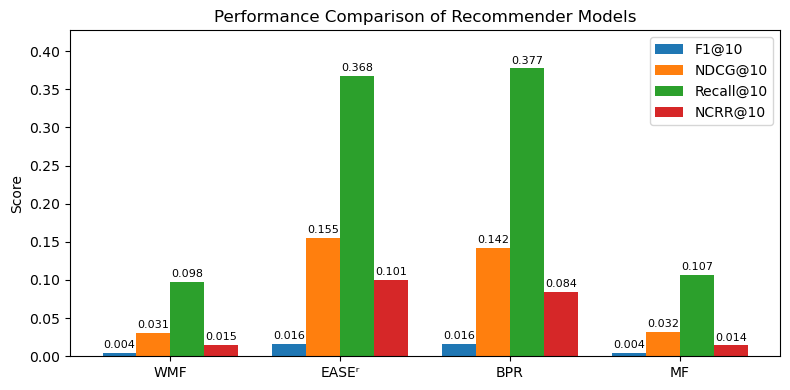

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Model names and metric values
models = ['WMF', 'EASEʳ', 'BPR', 'MF']
f1     = [0.0040, 0.0159, 0.0162, 0.0045]
ndcg   = [0.0307, 0.1549, 0.1423, 0.0321]
recall = [0.0976, 0.3679, 0.3772, 0.1068]
ncrr   = [0.0153, 0.1006, 0.0840, 0.0144]  # NCRR@50 for each model

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 4))

# Plot grouped bars
bars_f1    = ax.bar(x - 1.5*width, f1,   width, label='F1@10',   color='#1f77b4')
bars_ndcg  = ax.bar(x - 0.5*width, ndcg, width, label='NDCG@10', color='#ff7f0e')
bars_recall= ax.bar(x + 0.5*width, recall,width, label='Recall@10', color='#2ca02c')
bars_ncrr  = ax.bar(x + 1.5*width, ncrr,  width, label='NCRR@10', color='#d62728')

# Labels and format
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Score')
ax.set_title('Performance Comparison of Recommender Models')
ax.legend()

# Add value labels
for bars in [bars_f1, bars_ndcg, bars_recall, bars_ncrr]:
    ax.bar_label(bars, fmt='%.3f', padding=2, fontsize=8)

plt.ylim(0, max(recall + ncrr) + 0.05)
plt.tight_layout()
plt.show()


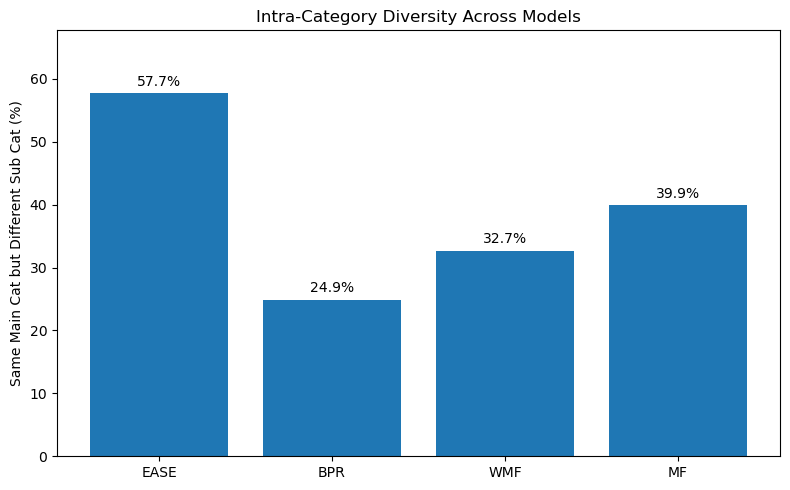

In [105]:
import numpy as np
import matplotlib.pyplot as plt

models = ['EASE', 'BPR', 'WMF', 'MF']
diversity = [0.5770, 0.2490, 0.3270, 0.3990]  # proportions

# Convert to percentages
div_pct = [d * 100 for d in diversity]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(models, div_pct, color='#1f77b4')

ax.set_ylim(0, max(div_pct) + 10)
ax.set_ylabel('Same Main Cat but Different Sub Cat (%)')
ax.set_title('Intra‑Category Diversity Across Models')

# Add value annotation on each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
